In [ ]:
!pip install -q pycaret[models]
!pip install -q pycaret[tuners]
# !pip install -q pycaret[analysis]
!pip install -q optuna
# !pip install -q lime
# !pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 5.7 MB/s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, fbeta_score

# 1.데이터 로드


In [ ]:
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_Labeled_50.csv')

In [ ]:
# df_org 복사 => df
df = df_org.copy()

In [ ]:
# df.head(3)
print('기지국 기기 개수 : {}개'.format(df.machine_id.nunique()))

기지국 기기 개수 : 51개


In [ ]:
# 수치형 변수 목록
target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

In [ ]:
# df[df[target_columns] < 0].isna().sum()

# 2.누락 데이터 보간

In [ ]:
# 전체 데이터 shape
df.shape

(61633, 16)

In [ ]:
# 시간 변수 생성
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [ ]:
df.head(2)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
0,MA1074_4_20210901_0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,7.873696,11.028859,27753.51401,0,2021-09-01 00:00:00
1,MA1074_4_20210901_1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,6.947635,10.664447,19952.83154,0,2021-09-01 01:00:00


## 2.1 시간 기준 키값 생성
- 누락된 시간대를 생성하기 위해, 원본 데이터와 join할 수 있는 고유키 역할의 기준 컬럼(기지국, 시간) 생성

In [ ]:
start_date = df['time'].min() # 시작날짜
end_date = df['time'].max() # 끝날짜
print('시작 날짜 : {}'.format(start_date))
print('종료 날짜 : {}'.format(end_date))
time_index = pd.date_range(start_date, end_date, freq='H')
print('전체 시간 인덱스 : {}개 \n{}'.format(len(time_index), time_index))

시작 날짜 : 2021-09-01 00:00:00
종료 날짜 : 2021-10-31 23:00:00
전체 시간 인덱스 : 1464개 
DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2021-10-31 14:00:00', '2021-10-31 15:00:00',
               '2021-10-31 16:00:00', '2021-10-31 17:00:00',
               '2021-10-31 18:00:00', '2021-10-31 19:00:00',
               '2021-10-31 20:00:00', '2021-10-31 21:00:00',
               '2021-10-31 22:00:00', '2021-10-31 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')


## 2.2 중복 행 삭제
- 원본 데이터 중 일부 중복 행(16쌍)이 발견되어 해당 행 모두 삭제
    - 2021년 9월 16일 16시 특정 시간대에 몇몇 기지국에 대해서 동일 데이터가 수집되었음
    - 중복된 행은 `tot_et`컬럼을 제외하고 모두 같은 값을 가지고 있음
    - `tot_et`변수의 range를 고려했을 때, 중복된 행 중 한 개만 골라 삭제할 수 있으나, 전체 6만개 행 중 *26개* 행은 대세에 영향이 없기 때문에 전체 삭제하는 방향으로 결정

In [ ]:
# 중복 행 확인
duplicated_row = df[df.duplicated(subset=['machine_id','time'], keep=False)]

print('중복된 행 개수(쌍): {}개'.format(duplicated_row.shape[0]))
duplicated_row.head(4)

중복된 행 개수(쌍): 26개


,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
351,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,322.14424,0,2021-09-16 16:00:00
352,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,37774.06968,0,2021-09-16 16:00:00
8887,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,313.88000,0,2021-09-16 16:00:00
8888,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,68408.51000,1,2021-09-16 16:00:00


In [ ]:
print("중복 제거 전 데이터 shape : {}".format(df.shape))
df = df.drop_duplicates(['machine_id', 'time'], keep=False)
print("중복 제거 후 데이터 shape : {}".format(df.shape))

중복 제거 전 데이터 shape : (61633, 17)
중복 제거 후 데이터 shape : (61607, 17)


## 2.3 df와 df_new 조인
- `machine_id`와 `time` 2개 컬럼에 대해 온전한 기준 데이터프레임(`df_new`) 생성
- 이후 원본 데이터(df)와 조인하여 누락된 시간대 복원

In [ ]:
# 기준 컬럼(df_new) 생성
df_new = pd.DataFrame()
machine_list = df.machine_id.unique()
for machine in machine_list:
    tmp = pd.DataFrame({
        'machine_id':[machine]*len(time_index),
        'time':time_index})
    df_new = pd.concat([df_new, tmp], axis=0)

In [ ]:
print("df_new 크기 : {}".format(df_new.shape))
df_new

df_new 크기 : (74664, 2)


,machine_id,time
0,MA1074_4,2021-09-01 00:00:00
1,MA1074_4,2021-09-01 01:00:00
2,MA1074_4,2021-09-01 02:00:00
3,MA1074_4,2021-09-01 03:00:00
4,MA1074_4,2021-09-01 04:00:00
...,...,...
1459,MA2561_18,2021-10-31 19:00:00
1460,MA2561_18,2021-10-31 20:00:00
1461,MA2561_18,2021-10-31 21:00:00
1462,MA2561_18,2021-10-31 22:00:00


In [ ]:
# df_new와 df 조인 (키 값=['machine_id', 'time'])
df_new = df_new.merge(df, on=['machine_id', 'time'], how='left')

In [ ]:
df_new.sample(3)

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
3832,MA1116_1,2021-10-08 16:00:00,MA1116_1_20211008_16,20211008.0,16.0,20.237222,32.0,97.565374,100.0,100.0,31.275164,13.054082,94.806806,12.338686,31.458795,22496.13586,0.0
9875,MA1266_5,2021-10-16 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67299,MA2467_5,2021-10-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4 y값 imputation
- 새로 채워진 시간대에 대한 y값은 `0` 레이블로 대체
 - <font color=yellow>해당 시간대에 대한 이상 판단 여부가 불확실하기 때문에 임의의 값으로 채우는 것보다 0으로 채우는 것이 안전하다고 판단</font>

In [ ]:
# 누락된 y레이블은 0으로 대체
df_new['y'] = df_new['y'].fillna(0)

In [ ]:
df_new.iloc[[3],:]

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# machine_list = df_new['machine_id'].unique()
# df_new['year'] = df_new['time'].dt.year # 년
# df_new['month'] = df_new['time'].dt.month # 월

# for idx, machine in enumerate(machine_list):
#     print(df_new.loc[df_new['machine_id'] == machine].groupby(['year', 'month']).size())

# 3.데이터 전처리
- 전체 51개의 기지국 기기 중 랜덤하게 10개 샘플링하여 테스트 진행

## 3.1 샘플링

In [ ]:
# 랜덤하게 10개 기기 선택
random_machine = list(np.random.choice(df_new.machine_id.unique(),2, replace=False))

In [ ]:
print(random_machine)

['MA2111_47', 'MA1584_1']


In [ ]:
# 10개 기기에 대한 데이터만 샘플링
df_test = df_new.loc[df_new['machine_id'].apply(lambda x: x in random_machine), :].reset_index(drop=True)

In [ ]:
# 샘플링 결과 검증
df_test.shape, 10 * 61 * 24

((2928, 17), 14640)

In [ ]:
df_test.head()

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
0,MA1584_1,2021-09-01 00:00:00,MA1584_1_20210901_0,20210901.0,0.0,18.030590,29.0,99.31271,99.57447,100.0,57.14848,26.160840,101.4706,8.166347,9.496422,32811.79,0.0
1,MA1584_1,2021-09-01 01:00:00,MA1584_1_20210901_1,20210901.0,1.0,15.838150,28.0,99.56140,100.00000,NaN,41.46420,15.546400,101.0425,9.600517,9.413200,37799.22,0.0
2,MA1584_1,2021-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,MA1584_1,2021-09-01 03:00:00,MA1584_1_20210901_3,20210901.0,3.0,10.763070,22.0,99.02913,100.00000,NaN,27.25794,5.722812,100.7888,8.575110,10.342600,20350.80,0.0
4,MA1584_1,2021-09-01 04:00:00,MA1584_1_20210901_4,20210901.0,4.0,7.944414,16.0,97.43590,100.00000,NaN,11.76751,3.641238,100.3840,8.931793,15.385780,20001.11,0.0


- 보간 시 음수로 채워진 값들은 0으로 변환
- 아래 그림과 같이 대부분의 변수에서 음수는 유효하지 않음
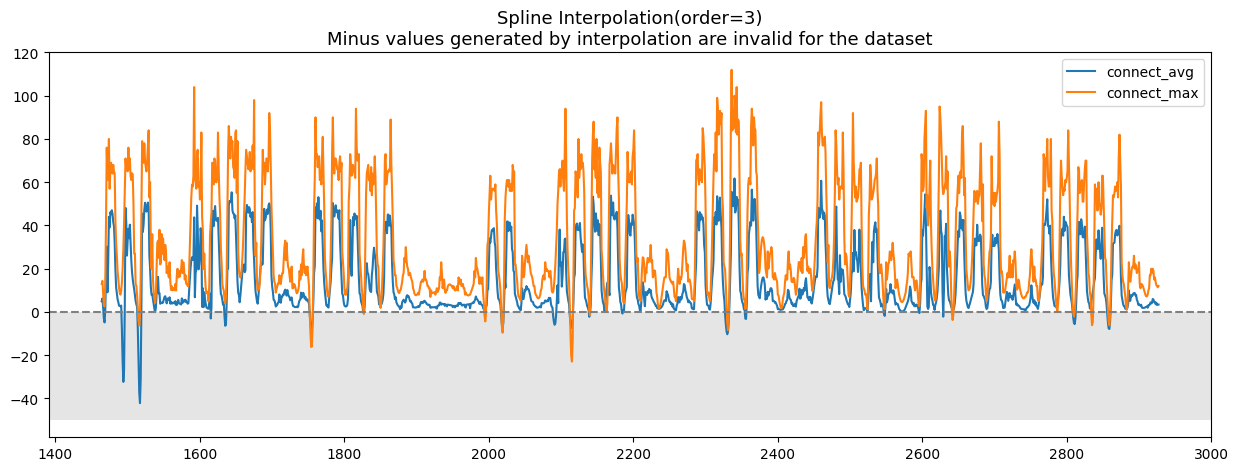

## 3.2 보간/로그차분/파생변수

In [ ]:
%%time
import holidays
from datetime import date

def preprocessing(df):
    # 보간&차분 적용 대상 컬럼 선정
    target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']
    # 기지국 고유 id 리스트
    machine_list = df['machine_id'].unique()

    for idx, machine in enumerate(machine_list):
        # spline3로 결측치 보간 후 bfill로 나머지 결측치 채우기
        tmp = df.loc[df['machine_id'] == machine, target_columns].interpolate(method='spline', order=3).bfill()
        tmp[tmp < 0] = 0 # 음수값으로 보간된 수치에 대해서는 0으로 변환
        tmp = np.log1p(tmp).diff(periods=24, axis=0) # 로그 차분 24시간 적용, 0값 고려 log1p 적용
        df.loc[df['machine_id'] == machine, target_columns] = tmp # 변경된 값으로

    df = df.dropna(axis=0, subset=target_columns).reset_index(drop=True) # 로그 차분 결과 발생한 nan 행 제거

    # 시간 파생변수 생성
    df['year'] = df['time'].dt.year # 년
    df['month'] = df['time'].dt.month # 월
    df['day'] = df['time'].dt.day # 일
    df['hour'] = df['time'].dt.hour # 시간
    df['dayofweek'] = df['time'].dt.dayofweek # 요일
    df['is_weekend'] = df['dayofweek'].apply(lambda x : 1 if x >= 5 else 0) # 주중/주말
    df['is_night'] = df['hour'].apply(lambda x : 1 if x >= 23 or x <= 7 else 0) # 주간/야간
    df['is_commute'] = df['hour'].apply(lambda x : 1 if (x >= 7 and x <= 9) or (x >= 17 and x <= 19) else 0)

    # cyclical encoding
    df['day_sin'] = np.sin(df['day'] / 31 * 2 * np.pi)
    df['day_cos'] = np.cos(df['day'] / 31 * 2 * np.pi)

    df['dayofweek_sin'] = np.sin(df['dayofweek'] / 7 * 2 * np.pi)
    df['dayofweek_cos'] = np.cos(df['dayofweek'] / 7 * 2 * np.pi)

    df['hour_sin'] = np.sin(df['hour'] / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['hour'] / 24 * 2 * np.pi)

    # 휴일 컬럼
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['time'].apply(lambda x : 1 if x in kr_holidays else 0)

    # 기지국 파생변수 생성
    df['station'] = df['machine_id'].apply(lambda x : x.split('_')[0])
    return df

df_try = df_new.copy() # 원본 수정 없이 반복적으로 테스트 시행을 위해 df_try에 copy
df_processed = preprocessing(df_try)
df_processed

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

CPU times: user 1min 1s, sys: 128 ms, total: 1min 1s
Wall time: 1min 4s


,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,...,is_night,is_commute,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,is_holiday,station
0,MA1074_4,2021-09-02 00:00:00,MA1074_4_20210902_0,20210902.0,0,-0.016140,0.058841,-0.003187,0.000000,0.000000,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.000000,1.000000,0,MA1074
1,MA1074_4,2021-09-02 01:00:00,MA1074_4_20210902_1,20210902.0,1,-0.040375,-0.039221,-0.381298,0.004795,0.006286,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.258819,0.965926,0,MA1074
2,MA1074_4,2021-09-02 02:00:00,NaN,NaN,2,0.060340,-0.163080,-0.067532,0.005599,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.500000,0.866025,0,MA1074
3,MA1074_4,2021-09-02 03:00:00,MA1074_4_20210902_3,20210902.0,3,0.226949,-0.007034,0.003485,-0.000007,0.001350,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.707107,0.707107,0,MA1074
4,MA1074_4,2021-09-02 04:00:00,NaN,NaN,4,0.175298,0.090093,-0.077281,-0.000262,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.866025,0.500000,0,MA1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73435,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19,-0.126192,-0.147636,-0.001250,0.006266,0.000000,...,0,1,-2.449294e-16,1.000000,-0.781831,0.623490,-0.965926,0.258819,0,MA2561
73436,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20,-0.093788,0.133531,0.003230,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.866025,0.500000,0,MA2561
73437,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21,0.408807,0.241162,0.004017,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.707107,0.707107,0,MA2561
73438,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22,0.177838,0.168623,0.003581,-0.004771,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.500000,0.866025,0,MA2561


In [ ]:
# df_processed[['connect_avg', 'connect_max']].plot(kind='line', figsize=(15,5))
# plt.title('Spline Interpolation(order=3)\nMinus values generated by interpolation are invalid for the dataset', fontsize=13)
# plt.axhline(0, linestyle='--', color='grey')
# ax = plt.gca()
# ymin, ymax = ax.get_ylim()
# plt.axhspan(ymin, 0, facecolor='grey', alpha=0.2)
# plt.show()

In [ ]:
df.y.value_counts()/df.shape[0],\
df_processed.y.value_counts()/df_processed.shape[0]

(0    0.850439
 1    0.149561
 Name: y, dtype: float64,
 0.0    0.876974
 1.0    0.123026
 Name: y, dtype: float64)

## 3.3 분리/스케일링/인코딩

In [ ]:
def split_scaling_encoding(df, preprocessing=False, to_automl=False):
    X = df.drop(['ckey', 'date', 'time', 'y'], axis=1)
    y = df['y']

    categorical_columns = ['station', 'machine_id', 'year', 'month']
    numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']


    preprocessor = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (OneHotEncoder(sparse_output=False), categorical_columns),
        remainder='passthrough'
    )

    if not to_automl: # to_automl이 False인 경우 분리, 스케일링, 인코딩 처리
        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

        if not preprocessing:
            return X_train, X_test, y_train, y_test
        else:
            X_train_processed = preprocessor.fit_transform(X_train)
            X_test_processed = preprocessor.transform(X_test)
            return X_train_processed, X_test_processed, y_train, y_test, preprocessor

    else: # to_automl이 True인 경우 X, y만 분리 후 return
        return X, y

X_train_p, X_test_p, y_train, y_test, preprocessor = split_scaling_encoding(df_processed, preprocessing=True, to_automl=False)

X, y = split_scaling_encoding(df_processed, preprocessing=False, to_automl=True)

In [ ]:
# X = df_processed.drop(['ckey', 'date', 'time', 'y'], axis=1)
# y = df_processed['y']

In [ ]:
# categorical_columns = ['station', 'machine_id', 'year', 'month']
# numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

In [ ]:
# preprocessor = make_column_transformer(
#     (StandardScaler(), numerical_columns),
#     (OneHotEncoder(sparse_output=False), categorical_columns),
# )

In [ ]:
# train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

In [ ]:
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [ ]:
# pd.DataFrame(X_train_p, columns=preprocessor.get_feature_names_out())

In [ ]:
# X_train_p.shape, X_test_p.shape, y_train.shape, y_test.shape

In [ ]:
X.shape, y.shape

((73440, 28), (73440,))

# 4.AutoML

In [ ]:
# !pip install -q --pre pycaret
# !pip install -q pycaret[models]

In [ ]:
# !pip install -q catboost

## 4.1 환경설정

In [ ]:
from pycaret.utils import version
# from catboost import CatBoostClassifier
version()

'3.2.0'

In [ ]:
from pycaret.classification import *

## 4.2 모델 튜닝

In [ ]:
categorical_features = ['station', 'machine_id', 'year', 'month']

numerical_features = ['connect_avg', 'connect_max', 'in_handover_rate',
                    'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb',
                    'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

passthrough = ['is_weekend', 'is_night', 'is_commute', 'is_holiday', 'day_sin',
               'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos']

ignore_features = ['day', 'dayofweek', 'hour']

In [ ]:
smote_s = setup(data=X, target=y,
                session_id=124,
                train_size=0.8, fold=5, verbose=True,
                ordinal_features=None,
                categorical_features=categorical_features,
                numeric_features=numerical_features,
                keep_features = passthrough,
                max_encoding_ohe=-1,
                # max_encoding_ohe=25,
                normalize=True,
                normalize_method='zscore',
                fold_strategy='stratifiedkfold',
                fold_shuffle=True,
                fix_imbalance=True)

,Description,Value
0,Session id,124
1,Target,y
2,Target type,Binary
3,Original data shape,"(73440, 29)"
4,Transformed data shape,"(117736, 126)"
5,Transformed train set shape,"(103048, 126)"
6,Transformed test set shape,"(14688, 126)"
7,Ordinal features,1
8,Numeric features,11
9,Categorical features,4


In [ ]:
# custom metric 정의
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# custom metric 추가
add_metric('f2', 'F2', f2_score, target='pred')

Name                                                                F2
Display Name                                                        F2
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                           make_scorer(f2_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: f2, dtype: object

In [ ]:
def f0_5_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)

add_metric('f0_5', 'F0.5', f0_5_score, target='pred')

Name                                                              F0.5
Display Name                                                      F0.5
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                         make_scorer(f0_5_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: f0_5, dtype: object

In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7e8361b2f130>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7e8361b2f250>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7e8361b2f370>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f2,F2,F2,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f2_score),pred,{},True,True,True
f0_5,F0.5,F0.5,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f0_5_score),pred,{},True,True,True


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
%%time
xgboost = create_model('xgboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,F0.5
Fold,,,,,,,,,
0,0.9003,0.9187,0.5781,0.5984,0.5881,0.5314,0.5316,0.5821,0.5943
1,0.9033,0.9290,0.5954,0.6098,0.6025,0.5475,0.5476,0.5982,0.6069
2,0.9037,0.9235,0.5654,0.6189,0.5910,0.5365,0.5372,0.5754,0.6074
3,0.9027,0.9205,0.5799,0.6099,0.5945,0.5393,0.5395,0.5857,0.6037
4,0.9020,0.9227,0.5809,0.6061,0.5932,0.5375,0.5377,0.5858,0.6009
Mean,0.9024,0.9229,0.5800,0.6086,0.5939,0.5385,0.5387,0.5854,0.6026
Std,0.0012,0.0035,0.0095,0.0066,0.0048,0.0052,0.0052,0.0074,0.0048


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 15 s, sys: 1.31 s, total: 16.3 s
Wall time: 1min


In [ ]:
# params = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [31, 63, 127],
#     'n_estimators': [100, 200, 500]
# }

In [ ]:
# params = {"max_depth": [5,10,15,20,25],
#           "max_features": np.random.randint(1, len(boston.columns),20),
#           "min_samples_leaf": [2,3,4,5,6]}

In [ ]:
%%time
tuned_xgboost = tune_model(xgboost, optimize = 'F0.5', fold=3, n_iter=50)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:12:57
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# default model
print(xgboost)

# tuned model
print(tuned_xgboost)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)


NameError: name 'tuned_xgboost' is not defined

In [ ]:
# !pip install -q pycaret[tuners]
# !pip install -q optuna

In [ ]:
# %%time
# tuned_model_optuna = tune_model(rf, search_library = 'optuna')

In [ ]:
# tuned_model_optuna

In [ ]:
# tuned_model_hyperopt, tuner_optuna_hyperopt = tune_model(lgbm, search_library = 'tune-sklearn', search_algorithm = 'hyperopt')

## 4.3 threshold 변경

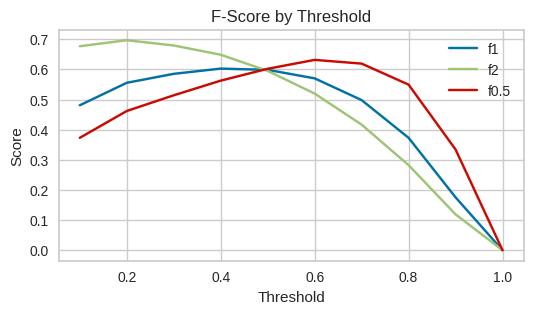

In [ ]:
# threshold 리스트
thresholds = np.linspace(0.1, 1, 10)

# score 저장 리스트
f1_scores = []
f2_scores = []
f0_5_scores = []
accuracy_scores = []

X = smote_s.X_test_transformed
y = smote_s.y_test

for threshold in thresholds:
    predictions = lgbm.predict_proba(X)[:, 1]
    predictions = np.where(predictions > threshold, 1, 0)
    f1_scores.append(fbeta_score(y, predictions, beta=1))
    f2_scores.append(fbeta_score(y, predictions, beta=2))
    f0_5_scores.append(fbeta_score(y, predictions, beta=0.5))
    accuracy_scores.append(accuracy_score(y, predictions))

# 그래프 그리기
plt.figure(figsize=(6,3))
plt.plot(thresholds, f1_scores, label = 'f1')
plt.plot(thresholds, f2_scores, label = 'f2')
plt.plot(thresholds, f0_5_scores, label = 'f0.5')
# plt.plot(thresholds, accuracy_scores, label = 'accuracy')
plt.title('F-Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
predictions = xgboost.predict_proba(X)[:, 1]
predictions = np.where(predictions > 0.6, 1, 0)

In [ ]:
confusion_matrix(y, predictions)

array([[12464,   417],
       [  920,   887]])

In [ ]:
predictions = xgboost.predict_proba(X)[:, 1]
predictions = np.where(predictions > 0.5, 1, 0)
confusion_matrix(y, predictions)

array([[12180,   701],
       [  736,  1071]])

# 5.Zscore


In [ ]:
from scipy.stats import zscore

In [ ]:
zscore_df = df_processed[target_columns]

In [ ]:
zscore_df

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
0,-0.016140,0.058841,-0.003187,0.000000,0.000000,-0.128298,-0.927531,0.019080,0.055756,-0.022035,0.212200
1,-0.040375,-0.039221,-0.381298,0.004795,0.006286,0.081664,-0.919199,0.015582,0.187271,0.518314,-0.047953
2,0.060340,-0.163080,-0.067532,0.005599,-0.001361,0.266548,-0.440348,0.007307,0.115528,0.425684,-0.287069
3,0.226949,-0.007034,0.003485,-0.000007,0.001350,0.012500,-0.453520,-0.016292,0.013146,-0.382483,0.114266
4,0.175298,0.090093,-0.077281,-0.000262,-0.001361,-0.366746,-1.223239,-0.002125,0.030046,-0.720330,0.138850
...,...,...,...,...,...,...,...,...,...,...,...
73435,-0.126192,-0.147636,-0.001250,0.006266,0.000000,0.183253,0.281329,-0.000098,-0.114350,-0.020999,-0.108241
73436,-0.093788,0.133531,0.003230,0.000000,0.000000,-0.021939,0.275821,-0.000393,-0.126718,0.051505,-0.015961
73437,0.408807,0.241162,0.004017,0.000000,0.000000,0.004103,0.385658,0.001281,-0.235796,0.113865,0.149389
73438,0.177838,0.168623,0.003581,-0.004771,0.000000,0.018482,-0.257566,-0.004550,-0.191984,-0.076920,0.143955


In [ ]:
zscore(zscore_df)

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
0,-0.028265,0.110807,-0.023510,-0.001064,0.000009,-0.198337,-1.437082,0.331682,0.109418,-0.039351,0.110212
1,-0.075946,-0.066502,-1.325574,0.423962,0.040307,0.133345,-1.424136,0.268705,0.369599,0.894121,-0.016385
2,0.122205,-0.290457,-0.245087,0.495292,-0.008712,0.425410,-0.680095,0.119757,0.227668,0.734099,-0.132746
3,0.449997,-0.008304,-0.000533,-0.001685,0.008663,0.024085,-0.700561,-0.305048,0.025122,-0.662039,0.062555
4,0.348377,0.167316,-0.278660,-0.024321,-0.008717,-0.575019,-1.896555,-0.050029,0.058556,-1.245682,0.074518
...,...,...,...,...,...,...,...,...,...,...,...
73435,-0.244785,-0.262533,-0.016839,0.554422,0.000009,0.293827,0.441250,-0.013535,-0.227109,-0.037561,-0.045723
73436,-0.181033,0.245859,-0.001410,-0.001064,0.000009,-0.030320,0.432692,-0.018856,-0.251577,0.087691,-0.000817
73437,0.807791,0.440471,0.001298,-0.001064,0.000009,0.010819,0.603358,0.011278,-0.467370,0.195421,0.079647
73438,0.353374,0.309309,-0.000203,-0.424043,0.000009,0.033535,-0.396088,-0.093679,-0.380695,-0.134168,0.077002


In [ ]:
def ucl(series, z=2):
    ucl = series.mean() + series.std() * z
    return np.where(series > ucl, 1, 0)

def lcl(series, z=2):
    lcl = series.mean() - series.std() * z
    return np.where(series < lcl, 1, 0)

def side(series, z=2):
    ucl = series.mean() + series.std() * z
    lcl = series.mean() - series.std() * z
    return np.where((series > ucl) | (series < lcl), 1, 0)

def outlier_zscore(df, col):
    if col in ['lower_prb', 'upper_prb', 'lower_bler', 'upper_bler']:
        return ucl(df[col]), 'ucl'
    elif col in ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'tot_et']:
        return lcl(df[col]), 'lcl'
    else:
        return side(df[col]), 'side'

In [ ]:
np.unique(ucl(zscore_df['connect_avg']), return_counts=True)

(array([0, 1]), array([71443,  1997]))

In [ ]:
tmp = zscore_df.copy()
anomalies_df = pd.DataFrame()
for col in tmp.columns:
    res, typ = outlier_zscore(tmp, col)
    anomalies_df[f'{col}_z'] = res
    print(f'{col}의 이상치 비율은 {np.round(np.mean(res)*100, 2)}%({typ})')

connect_avg의 이상치 비율은 2.58%(lcl)
connect_max의 이상치 비율은 2.22%(lcl)
in_handover_rate의 이상치 비율은 0.93%(lcl)
out_handover_rate의 이상치 비율은 0.81%(lcl)
inter_handover_rate의 이상치 비율은 0.24%(lcl)
lower_prb의 이상치 비율은 2.86%(ucl)
upper_prb의 이상치 비율은 3.07%(ucl)
reconfig_rate의 이상치 비율은 0.92%(side)
lower_bler의 이상치 비율은 1.94%(ucl)
upper_bler의 이상치 비율은 1.99%(ucl)
tot_et의 이상치 비율은 2.7%(lcl)


In [ ]:
for (idx, col) in enumerate(target_columns):
    print(idx, col)

0 connect_avg
1 connect_max
2 in_handover_rate
3 out_handover_rate
4 inter_handover_rate
5 lower_prb
6 upper_prb
7 reconfig_rate
8 lower_bler
9 upper_bler
10 tot_et


In [ ]:
df_org[target_columns + ['y']].groupby('y').mean()

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
y,,,,,,,,,,,
0,21.090100,37.414727,96.653688,99.764482,99.781487,27.772763,25.775308,101.074137,12.013264,21.934688,39474.127589
1,19.283993,36.958388,92.617417,99.562896,99.523938,30.505702,32.385277,101.713289,19.712757,36.692422,35934.344164


In [ ]:
anomalies_df

,connect_avg_z,connect_max_z,in_handover_rate_z,out_handover_rate_z,inter_handover_rate_z,lower_prb_z,upper_prb_z,reconfig_rate_z,lower_bler_z,upper_bler_z,tot_et_z
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
73435,0,0,0,0,0,0,0,0,0,0,0
73436,0,0,0,0,0,0,0,0,0,0,0
73437,0,0,0,0,0,0,0,0,0,0,0
73438,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
anomalies_df['total'] = anomalies_df.mean(axis=1)

In [ ]:
anomalies_df['total'].sort_values(ascending=False)

66080    0.545455
65201    0.545455
65419    0.454545
20786    0.454545
20784    0.454545
           ...   
26308    0.000000
26309    0.000000
26310    0.000000
26311    0.000000
73439    0.000000
Name: total, Length: 73440, dtype: float64

In [ ]:
anomalies_df['total'].value_counts()

0.000000    63893
0.090909     5838
0.181818     2535
0.272727      835
0.363636      241
0.454545       96
0.545455        2
Name: total, dtype: int64

In [ ]:
anomalies_df[anomalies_df['total'] != 0]

,connect_avg_z,connect_max_z,in_handover_rate_z,out_handover_rate_z,inter_handover_rate_z,lower_prb_z,upper_prb_z,reconfig_rate_z,lower_bler_z,upper_bler_z,tot_et_z,total
102,0,0,0,0,0,0,0,1,0,0,0,0.090909
122,0,0,0,0,0,0,1,0,0,0,0,0.090909
148,0,0,0,0,0,0,1,0,0,0,0,0.090909
272,0,0,0,0,0,0,1,0,0,0,0,0.090909
315,0,0,0,0,0,1,1,0,0,0,0,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...
73383,0,0,0,0,0,0,0,0,0,1,0,0.090909
73418,0,0,0,0,0,0,1,0,0,0,0,0.090909
73419,0,0,1,0,0,0,0,0,0,0,0,0.090909
73429,0,0,1,0,0,0,0,0,1,0,0,0.181818


In [ ]:
9547 / df_processed.shape[0]

0.12999727668845315

# 6.Isolation Forest


In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
true_label = df_processed['y']

In [ ]:
clf = IsolationForest(n_estimators=500, random_state=0)
clf.fit(zscore_df)

IsolationForest(n_estimators=500, random_state=0)

In [ ]:
anomaly_score = -(clf.score_samples(zscore_df))

In [ ]:
anomaly_score

array([0.3268884 , 0.36422399, 0.33603504, ..., 0.32577502, 0.32325313,
       0.33198107])

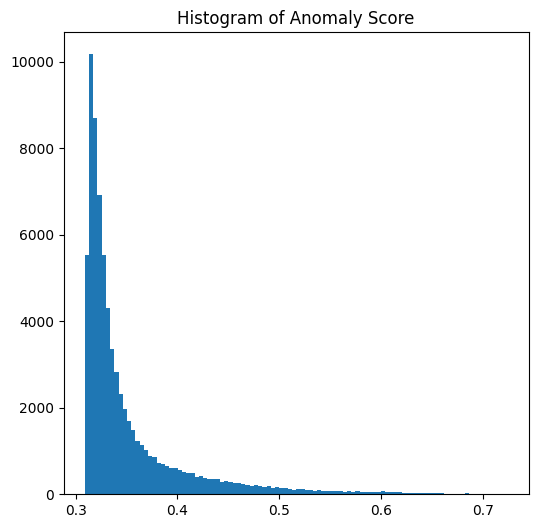

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(anomaly_score, bins=100)
plt.title("Histogram of Anomaly Score")
# sns.kdeplot(anomaly_score)
plt.show()

In [ ]:
i_forest_anomalies = np.where(clf.predict(zscore_df)==1, 0, 1)

In [ ]:
i_forest_anomalies

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print('Isolation Accuracy score :', accuracy_score(true_label, i_forest_anomalies).round(4))
print('Isolation F1 score :', f1_score(true_label, i_forest_anomalies).round(4))

Isolation Accuracy score : 0.8469
Isolation F1 score : 0.0478


# 7.통합

In [ ]:
from imblearn.over_sampling import SMOTE
X_train_s, y_train_s = SMOTE().fit_resample(X_train_p, y_train)

output
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [ ]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgb = xgboost.fit(X_train_s, y_train_s)
pred = xgb.predict(X_test_p)

print('XGB Accuracy score :', accuracy_score(y_test, pred).round(4))
print('XGB F1 score :', f1_score(y_test, pred).round(4))
print('XGB F0.5 score :', fbeta_score(y_test, pred, beta=0.5).round(4))
print('XGB F2 score :', fbeta_score(y_test, pred, beta=2).round(4))

XGB Accuracy score : 0.905
XGB F1 score : 0.596
XGB F0.5 score : 0.6132
XGB F2 score : 0.5798


(array([38665.,  5764.,  3098.,  2388.,  2002.,  1808.,  1505.,  1308.,
         1355.,   859.]),
 array([9.27096039e-07, 9.85183641e-02, 1.97035804e-01, 2.95553237e-01,
        3.94070685e-01, 4.92588133e-01, 5.91105580e-01, 6.89622998e-01,
        7.88140416e-01, 8.86657894e-01, 9.85175312e-01]),
 <BarContainer object of 10 artists>)

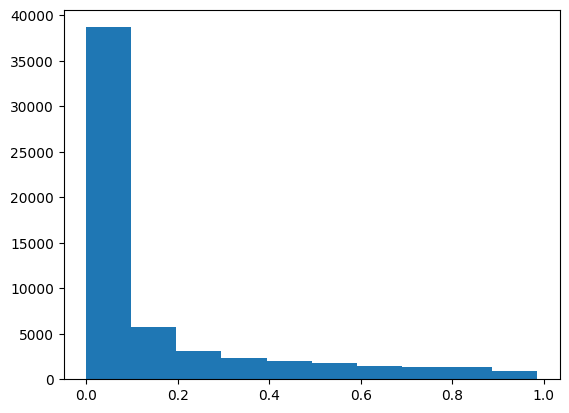

In [ ]:
plt.hist(xgb.predict_proba(X_train_p)[:,1])

In [ ]:
def split_scaling_encoding(df, split = True, preprocessing=False, to_automl=False):
    X = df.drop(['ckey', 'date', 'time', 'y'], axis=1)
    y = df['y']

    categorical_columns = ['station', 'machine_id', 'year', 'month']
    numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']


    preprocessor = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (OneHotEncoder(sparse_output=False), categorical_columns),
        remainder='passthrough'
    )

    if not to_automl: # to_automl이 False인 경우 분리, 스케일링, 인코딩 처리
        if split:
            # train_test_split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

            if not preprocessing:
                return X_train, X_test, y_train, y_test
            else:
                X_train_processed = preprocessor.fit_transform(X_train)
                X_test_processed = preprocessor.transform(X_test)
                return X_train_processed, X_test_processed, y_train, y_test, preprocessor
        else:
            if not preprocessing:
                return X, y
            else:
                X_processed = preprocessor.fit_transform(X)
                return X_processed, y, preprocessor

    else: # to_automl이 True인 경우 X, y만 분리 후 return
        return X, y

X, y, preprocessor = split_scaling_encoding(df_processed, split=True, preprocessing=True, to_automl=False)

In [ ]:
pred = xgb.predict(X)
print('XGB Accuracy score :', accuracy_score(y, pred).round(4))
print('XGB F1 score :', f1_score(y, pred).round(4))
print('XGB F0.5 score :', fbeta_score(y, pred, beta=0.5).round(4))
print('XGB F2 score :', fbeta_score(y, pred, beta=2).round(4))

XGB Accuracy score : 0.9166
XGB F1 score : 0.6715
XGB F0.5 score : 0.6592
XGB F2 score : 0.6842


In [ ]:
final = pd.DataFrame()

In [ ]:
final['Zscore'] = anomalies_df['total']
final['Probability'] = xgb.predict_proba(X)[:,1]
final['Isolation'] = anomaly_score

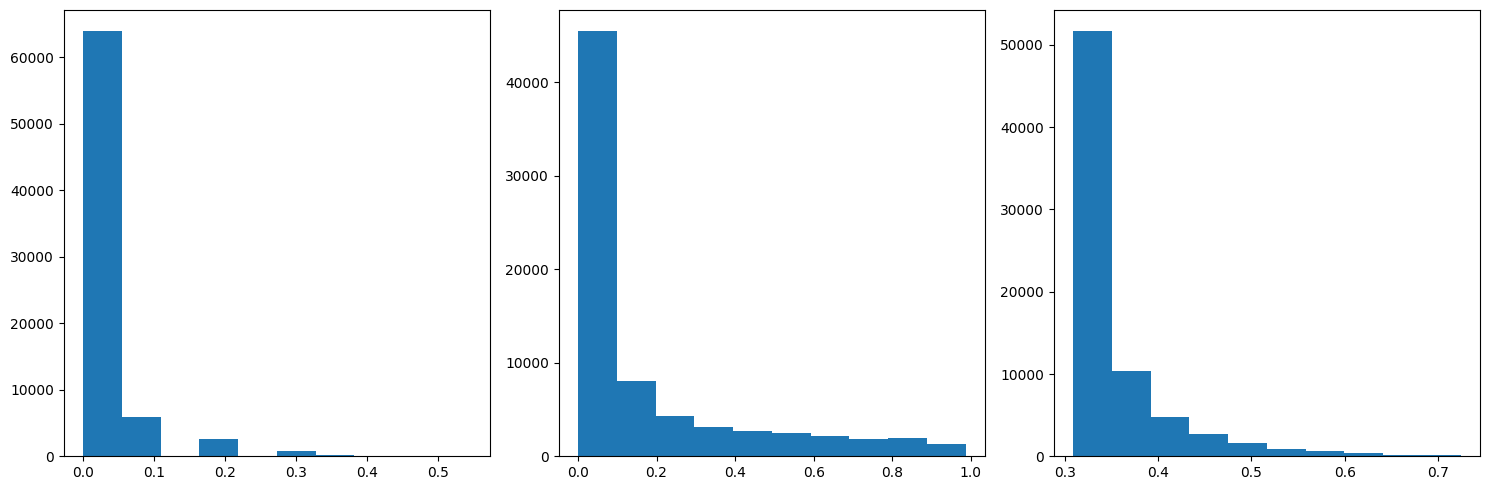

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(final['Zscore'], bins=10)
axs[1].hist(final['Probability'], bins=10)
axs[2].hist(final['Isolation'], bins=10)
plt.tight_layout()
plt.show()

In [ ]:
final['Zscore_rank'] = final['Zscore'].rank(ascending=False)
final['Probability_rank'] = final['Probability'].rank(ascending=False)
final['Isolation_rank'] = final['Isolation'].rank(ascending=False)

In [ ]:
final['Total_Score'] = (final['Zscore'] + final['Probability'] + final['Isolation']) / 3
final['Total_Rank'] = (final['Zscore_rank'] + final['Probability_rank'] + final['Isolation_rank']) / 3

<AxesSubplot: >

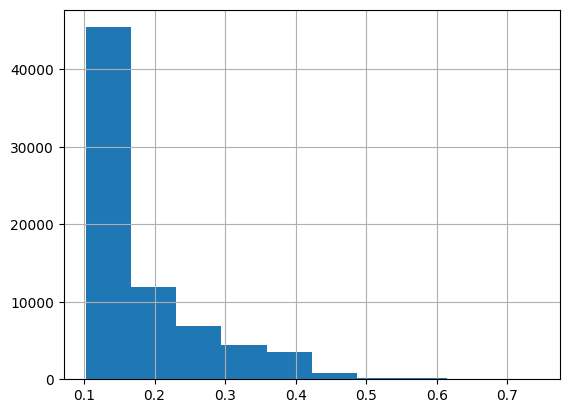

In [ ]:
final['Total_Score'].hist()

In [ ]:
rank_threshold = final['Total_Rank'].quantile(0.12)

Text(10000, 1000, '12%')

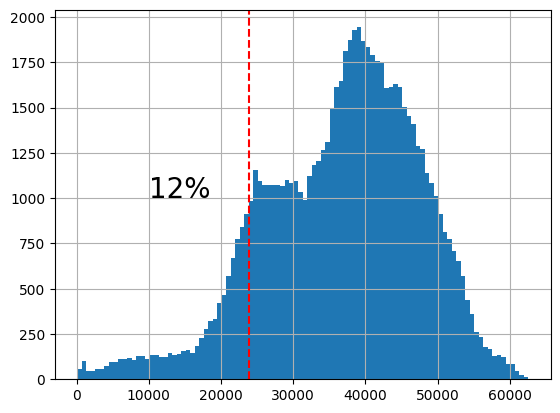

In [ ]:
final['Total_Rank'].hist(bins=100)
plt.axvline(rank_threshold, linestyle='--', color='red')
plt.text(10000, 1000, s='12%', color='black', fontsize=20)

In [ ]:
final['Final_Result'] = np.where(final['Total_Rank'] < rank_threshold, 1, 0)

In [ ]:
pred = final['Final_Result']
print('XGB Accuracy score :', accuracy_score(y, pred).round(4))
print('XGB F1 score :', f1_score(y, pred).round(4))
print('XGB F0.5 score :', fbeta_score(y, pred, beta=0.5).round(4))
print('XGB F2 score :', fbeta_score(y, pred, beta=2).round(4))

XGB Accuracy score : 0.827
XGB F1 score : 0.2881
XGB F0.5 score : 0.2903
XGB F2 score : 0.286


In [ ]:
final.shape

(73440, 9)

In [ ]:
final.to_csv('rank추가.csv', index=False)

# 8.Lime

In [ ]:
# !pip install -q lime

In [ ]:
# from lime import lime_tabular
# import random

# explainer = lime_tabular.LimeTabularExplainer(smote_s.X_train_transformed.values, mode="classification", feature_names= smote_s.X_test_transformed.columns, class_names=['0', '1'], verbose=True)

# idx = random.randint(1, len(smote_s.X_test_transformed))

# print("Prediction : ", rf.predict(smote_s.X_test_transformed.values[[0]]))
# print("Actual :     ", smote_s.y_test.values[0])

# explanation = explainer.explain_instance(smote_s.X_test_transformed.values[0], rf.predict_proba, num_features=len(smote_s.X_test_transformed.columns), labels=(0,1) ,num_samples=5000)

In [ ]:
# explanation.show_in_notebook()

In [ ]:
# X_test_p[[0]]

In [ ]:
# smote_s.dataset_transformed.columns

In [ ]:
# smote_s.X_train_transformed
# smote_s.X_test_transformed

In [ ]:
# !pip install -q shap
# !pip install -q pycaret[analysis]

In [ ]:
# import shap

In [ ]:
# interpret summary model
# interpret_model(rf, plot = 'summary')

# 결과 시각화

In [ ]:
%%time
import holidays
from datetime import date

def preprocessing(df):
    # 보간&차분 적용 대상 컬럼 선정
    target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']
    # 기지국 고유 id 리스트
    machine_list = df['machine_id'].unique()

    for idx, machine in enumerate(machine_list):
        # spline3로 결측치 보간 후 bfill로 나머지 결측치 채우기
        tmp = df.loc[df['machine_id'] == machine, target_columns].interpolate(method='spline', order=3).bfill()
        tmp[tmp < 0] = 0 # 음수값으로 보간된 수치에 대해서는 0으로 변환
        # tmp = np.log1p(tmp).diff(periods=24, axis=0) # 로그 차분 24시간 적용, 0값 고려 log1p 적용
        df.loc[df['machine_id'] == machine, target_columns] = tmp # 변경된 값으로

    df = df.dropna(axis=0, subset=target_columns).reset_index(drop=True) # 로그 차분 결과 발생한 nan 행 제거
    return df

df_try = df_new.copy() # 원본 수정 없이 반복적으로 테스트 시행을 위해 df_try에 copy
df_vis = preprocessing(df_try)
df_vis

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

CPU times: user 1min 4s, sys: 129 ms, total: 1min 4s
Wall time: 1min 6s


,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
0,MA1074_4,2021-09-01 00:00:00,MA1074_4_20210901_0,20210901.0,0.0,17.598889,32.000000,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,7.873696,11.028859,27753.51401,0.0
1,MA1074_4,2021-09-01 01:00:00,MA1074_4_20210901_1,20210901.0,1.0,13.039444,25.000000,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,6.947635,10.664447,19952.83154,0.0
2,MA1074_4,2021-09-01 02:00:00,MA1074_4_20210901_2,20210901.0,2.0,10.153889,23.000000,99.583333,99.411765,100.000000,16.333186,11.431835,101.656051,8.057850,9.488755,16330.00997,0.0
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,NaN,8.117240,19.141172,99.648623,100.000707,99.863755,19.401709,9.749610,104.190781,8.775205,11.593777,13779.67478,0.0
4,MA1074_4,2021-09-01 04:00:00,MA1074_4_20210901_4,20210901.0,4.0,9.346667,21.000000,100.000000,100.000000,100.000000,24.041863,16.660100,106.972789,8.878345,12.315908,15947.12178,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74659,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19.0,29.702220,43.000000,99.312710,100.000000,100.000000,27.742690,10.711980,100.263800,7.586300,9.831098,60634.85000,0.0
74660,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20.0,36.030560,63.000000,100.000000,100.000000,100.000000,29.958410,16.532760,100.412600,6.234337,9.195488,72844.89000,0.0
74661,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21.0,50.123890,69.000000,100.000000,100.000000,100.000000,38.585600,17.819100,100.494700,6.015570,9.389188,88259.65000,0.0
74662,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22.0,39.547780,57.000000,100.000000,99.519230,100.000000,41.989620,11.855160,100.000000,6.886077,10.370870,81633.56000,0.0


In [ ]:
df_tmp = df_vis[df_vis['time'] >= '2021-09-02'].reset_index(drop=True)

In [ ]:
df_final = pd.concat([df_tmp, final], axis=1)

In [ ]:
df_final

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,...,y,Zscore,Probability,Isolation,Total_Score,Zscore_rank,Probability_rank,Isolation_rank,Total_Rank,Final_Result
0,MA1074_4,2021-09-02 00:00:00,MA1074_4_20210902_0,20210902.0,0.0,17.301111,34.000000,99.442379,100.000000,100.000000,...,0.0,0.0,0.000109,0.326888,0.108999,41494.0,65840.0,40288.0,49207.333333,0
1,MA1074_4,2021-09-02 01:00:00,MA1074_4_20210902_1,20210902.0,1.0,12.483889,24.000000,67.748918,100.000000,100.000000,...,0.0,0.0,0.000119,0.364224,0.121448,41494.0,65355.0,17000.0,41283.000000,0
2,MA1074_4,2021-09-02 02:00:00,NaN,NaN,NaN,10.847636,19.388567,93.015051,99.975567,99.862681,...,0.0,0.0,0.000143,0.336035,0.112059,41494.0,64361.0,30459.0,45438.000000,0
3,MA1074_4,2021-09-02 03:00:00,MA1074_4_20210902_3,20210902.0,3.0,10.440000,19.000000,100.000000,100.000000,100.000000,...,0.0,0.0,0.000073,0.327040,0.109037,41494.0,67878.0,40075.0,49815.666667,0
4,MA1074_4,2021-09-02 04:00:00,NaN,NaN,NaN,11.329098,23.074076,92.488575,99.973506,99.862602,...,0.0,0.0,0.000047,0.356185,0.118744,41494.0,69708.0,19482.0,43561.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73435,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19.0,29.702220,43.000000,99.312710,100.000000,100.000000,...,0.0,0.0,0.025294,0.321427,0.115573,41494.0,41973.0,49043.0,44170.000000,0
73436,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20.0,36.030560,63.000000,100.000000,100.000000,100.000000,...,0.0,0.0,0.017409,0.311907,0.109772,41494.0,45002.0,70666.0,52387.333333,0
73437,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21.0,50.123890,69.000000,100.000000,100.000000,100.000000,...,0.0,0.0,0.013450,0.325775,0.113075,41494.0,46805.0,41825.0,43374.666667,0
73438,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22.0,39.547780,57.000000,100.000000,99.519230,100.000000,...,0.0,0.0,0.026989,0.323253,0.116747,41494.0,41349.0,45762.0,42868.333333,0


In [ ]:
df_2561_18 = df_final[df_final['machine_id'] == 'MA2561_18']

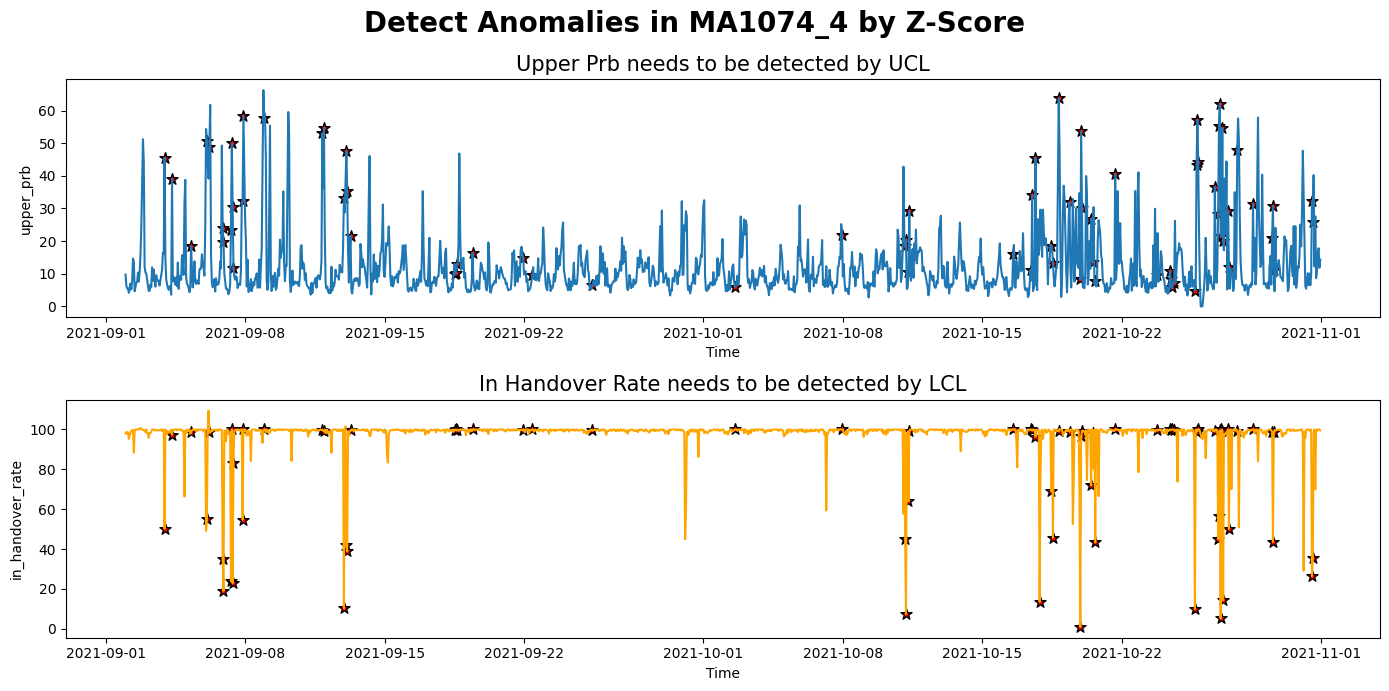

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(14,7))

plt.suptitle('Detect Anomalies in MA1074_4 by Z-Score', fontsize=20, fontweight='semibold')
### 95% ###
axs[0].plot(df_2561_18['time'], df_2561_18['upper_prb'])
axs[0].set_ylabel('upper_prb')
axs[0].set_xlabel('Time')

upper_prb_anomalies_95 = df_2561_18.loc[(df_2561_18['Final_Result'] != 0), ['time', 'upper_prb']]

for idx, (time, rate) in upper_prb_anomalies_95.iterrows():
    axs[0].scatter(pd.Timestamp(time), rate, marker='*', edgecolor='black', color='red', s=70)

# axs[0].axhspan(0, upper_prb_time_ucl2, color='green', alpha=0.1)
# axs[0].axhline(0, ls='--', color='green')
# axs[0].axhline(upper_prb_time_ucl2, ls='--', color='green')

axs[0].set_title('Upper Prb needs to be detected by UCL', fontsize=15)

axs[1].plot(df_2561_18['time'], df_2561_18['in_handover_rate'], color='orange')
axs[1].set_ylabel('in_handover_rate')
axs[1].set_xlabel('Time')

in_handover_rate_anomalies_95 = df_2561_18.loc[(df_2561_18['Final_Result'] != 0), ['time', 'in_handover_rate']]

for idx, (time, rate) in in_handover_rate_anomalies_95.iterrows():
    axs[1].scatter(pd.Timestamp(time), rate, marker='*', edgecolor='black', color='red', s=70)

# axs[1].axhspan(in_handover_rate_time_lcl2, 100, color='green', alpha=0.1)
# axs[1].axhline(100, ls='--', color='green')
# axs[1].axhline(in_handover_rate_time_lcl2, ls='--', color='green')

axs[1].set_title('In Handover Rate needs to be detected by LCL', fontsize=15)
plt.tight_layout()